## 1. Importing Libraries

In [2]:
import numpy as np     #ensure all these packages are installed in your env i.e ml_render in this case
import pandas as pd
import sklearn 
import joblib 
import matplotlib.pyplot as plt

## 2. Display Settings

In [4]:
pd.set_option("display.max_columns", None)     #will show all the columns for better readability

In [5]:
#sklearn.set_config(transform_output="pandas")  #to convert transformers in sklearn eg. StandardScalar etc from  numpy array to pandas dft
sklearn.set_config(transform_output="default")     # change to default while running app.py

## 3. Getting The Data

In [7]:
train_df = pd.read_csv("E:/IIT Bombay/Placements/Projects/ML with Deployment/Flight Price Predictions_CampusX/Data/train.csv")
val_df = pd.read_csv("E:/IIT Bombay/Placements/Projects/ML with Deployment/Flight Price Predictions_CampusX/Data/val.csv")
test_df = pd.read_csv("E:/IIT Bombay/Placements/Projects/ML with Deployment/Flight Price Predictions_CampusX/Data/test.csv")

In [8]:
train_df.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Jet Airways,2019-06-21,Mumbai,Hyderabad,10:20:00,11:50:00,90,0.0,In-flight meal not included,4995
1,Air India,2019-05-18,Delhi,Cochin,09:00:00,07:40:00,1360,1.0,No Info,8372
2,Air India,2019-06-12,Kolkata,Banglore,09:10:00,11:05:00,1555,2.0,No Info,6117
3,Vistara,2019-04-01,Kolkata,Banglore,20:20:00,22:55:00,1595,1.0,No Info,7770
4,Vistara,2019-06-06,Kolkata,Banglore,17:00:00,10:45:00,1065,1.0,No Info,9187


### 3.1 Split the Data


In [10]:
def split_data(data): # creating a function for splitting into Target and Input variables
    X = data.drop(columns="price")
    y = data.price.copy()
    return (X,y)

In [11]:
X_train, y_train = split_data(train_df)

In [12]:
y_train.head()


0    4995
1    8372
2    6117
3    7770
4    9187
Name: price, dtype: int64

In [13]:
X_val, y_val = split_data(val_df)
print(X_val.shape, y_val.shape)

(160, 9) (160,)


In [14]:
X_test, y_test = split_data(test_df)
print(X_test.shape, y_test.shape)

(200, 9) (200,)


### 3.2 Meta-Info

In [16]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640 entries, 0 to 639
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   airline          640 non-null    object 
 1   date_of_journey  640 non-null    object 
 2   source           640 non-null    object 
 3   destination      640 non-null    object 
 4   dep_time         640 non-null    object 
 5   arrival_time     640 non-null    object 
 6   duration         640 non-null    int64  
 7   total_stops      640 non-null    float64
 8   additional_info  640 non-null    object 
dtypes: float64(1), int64(1), object(7)
memory usage: 45.1+ KB


## 4. Data Preprocessing

In [18]:
dt_cols = ["date_of_journey", "dep_time", "arrival_time"]

num_cols = ["duration", "total_stops"]

cat_cols = [col for col in X_train.columns if (col not in dt_cols) and (col not in num_cols)]

In [19]:
cat_cols

['airline', 'source', 'destination', 'additional_info']

In [20]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from feature_engine.datetime import DatetimeFeatures     # converts date cols to 'datetime' type using pandas and extract the format of datetime

In [21]:
num_transformer = Pipeline(steps=[                        # Pipeline defines a set of operations to be performed
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(sparse_output= False, handle_unknown="ignore"))
])

doj_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["month", "week", "day_of_week", "day_of_month"], format="mixed")),
    ("scaler", StandardScaler())
])

time_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("extractor", DatetimeFeatures(features_to_extract=["hour", "minute"], format="mixed")),
    ("scaler", StandardScaler())
])



In [22]:
preprocesser = ColumnTransformer(transformers=[     # helps to apply a seq on operations on a set of columns
    ("num", num_transformer, num_cols),
    ("cat", cat_transformer, cat_cols),
    ("doj", doj_transformer, ["date_of_journey"]),
    ("time", time_transformer, ["dep_time", "arrival_time"] )
])   

In [23]:
preprocesser.fit_transform(X_train)    # if in cell 2, we set tranform_output to pandas, this will be shown as pandas dataframe

array([[-1.09591823, -1.21213152,  0.        , ..., -0.14005709,
        -0.34523131,  1.49385907],
       [ 1.43569944,  0.31797533,  0.        , ..., -1.22986299,
        -0.93560684,  0.89104078],
       [ 1.82441239,  1.84808218,  0.        , ..., -0.68496004,
        -0.34523131, -1.21882323],
       ...,
       [-0.94641325, -1.21213152,  0.        , ..., -0.95741152,
        -0.78801296,  1.49385907],
       [ 0.18982461,  0.31797533,  0.        , ...,  1.22220029,
         1.1307075 , -1.52023237],
       [ 0.63833955,  0.31797533,  0.        , ..., -1.22986299,
        -0.19763743, -1.52023237]])

## 5. Model Selection

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import r2_score
from sklearn.model_selection import learning_curve

In [26]:
combined_data = pd.concat([train_df, val_df], axis=0)

X_data, y_data = split_data(combined_data)
print(X_data.shape, y_data.shape)

(800, 9) (800,)


In [27]:
algorithms = {
    "Linear Regression": LinearRegression(),
    "SVM": SVR(),
    "Random Forest": RandomForestRegressor(n_estimators=10),
    "XG Boost": XGBRegressor(n_estimators=10)
}

In [28]:
def plot_curves(sizes, mean_scores, std_scores, label, ax):
    ax.plot(
        sizes,
        mean_scores,
        marker="o",
        label=label
    )
    ax.fill_between(
        x=sizes,
        y1=mean_scores - std_scores,
        y2=mean_scores + std_scores,
        alpha = 0.5
    )
    

In [29]:
def plot_learning_curves(name, algorithm, figsize=(12,4)):
    model = Pipeline(steps=[
        ("pre", preprocesser),
        ("alg", algorithm)
    ])

    train_sizes, train_scores, test_scores = learning_curve(
        estimator = model,
        X = X_data,
        y = y_data,
        cv = 3,
        scoring = "r2",
        n_jobs = -1,
        random_state = 42
    )

    mean_train_scores = np.mean(train_scores, axis=1)
    std_train_scores = np.std(train_scores, axis=1)
    final_train_score = f"{mean_train_scores[-1]:.2f} +/- {std_train_scores[-1]:.2f}"
    
    mean_test_scores = np.mean(test_scores, axis=1)
    std_test_scores = np.std(test_scores, axis=1)
    final_test_score = f"{mean_test_scores[-1]:.2f} +/- {std_test_scores[-1]:.2f}"

    fig, ax = plt.subplots(figsize = figsize)
    
    # train curve
    plot_curves(
        train_sizes,
        mean_train_scores,
        std_train_scores,
        f"Train ({final_train_score})",
        ax
    )

    # test curve
    plot_curves(
        train_sizes,
        mean_test_scores,
        std_test_scores,
        f"Test ({final_test_score})",
        ax
    )

    ax.set(xlabel="Training Set Size", ylabel="R-squared", title=name)
    ax.legend(loc="upper right")

    plt.show()

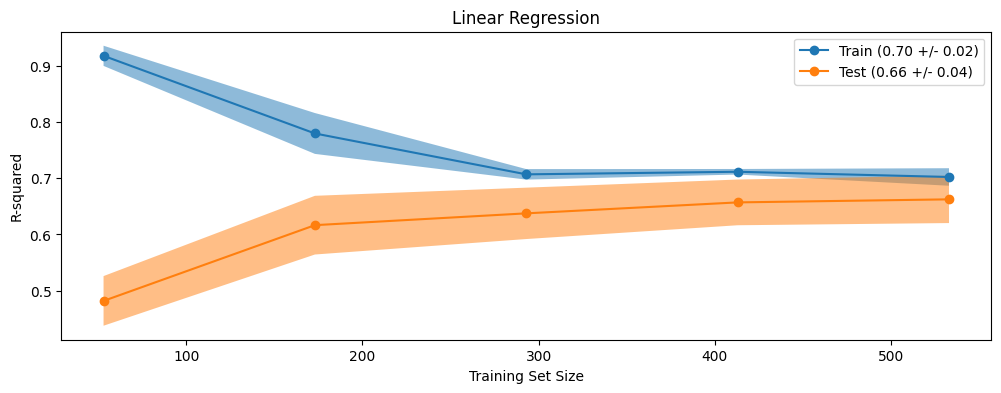

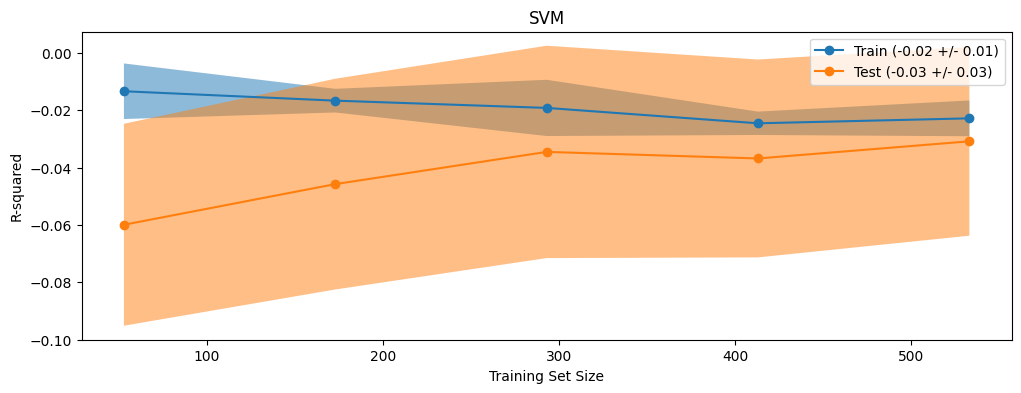

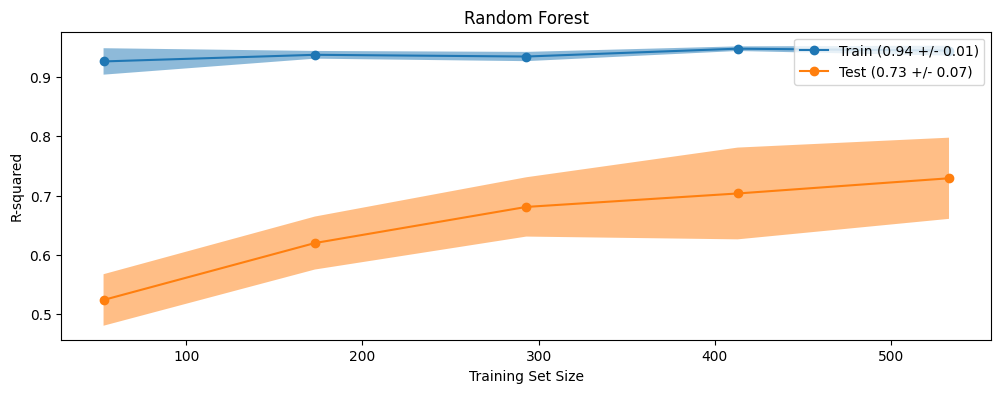

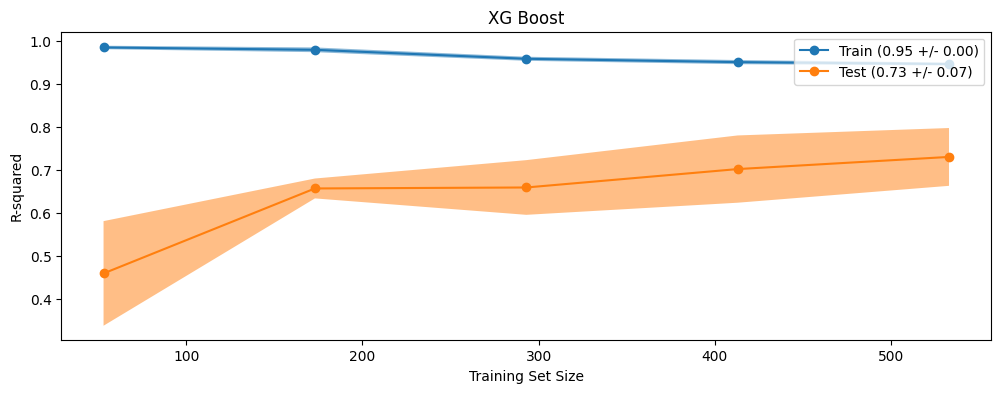

In [30]:
for name, alg in algorithms.items():
    plot_learning_curves(name, alg)

## 6. Model Training

In [32]:
model = Pipeline(steps=[
        ("pre", preprocesser),
        ("rf", RandomForestRegressor(n_estimators=10))
    ])

In [33]:
model.fit(X_data, y_data)

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

## 7. Model Evaluation

In [35]:
def evaluate_model(X,y):
    y_pred = model.predict(X)
    return r2_score(y, y_pred)

In [36]:
print(f"R2 score on training data is = {evaluate_model(X_data, y_data)}")

R2 score on training data is = 0.9507721024487422


In [37]:
print(f"R2 score on training data is = {evaluate_model(X_test, y_test)}")

R2 score on training data is = 0.6796154012499551


## 8. Model Persistence

In [39]:
joblib.dump(model, "model.joblib")

['model.joblib']

In [40]:
saved_model = joblib.load("model.joblib")
saved_model

Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['duration', 'total_stops']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  ['airline', 'source',
                                                   '...
                                                                                                         'day_of_month'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['date_of_journey']),
                                                 ('time',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('extractor',
                                                                   DatetimeFeatures(features_to_extract=['hour',
                                                                                                         'minute'],
                                                                                    format='mixed')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['dep_time',
                                                   'arrival_time'])])),
                ('rf', RandomForestRegressor(n_estimators=10))])

In [41]:
y_pred = saved_model.predict(X_test)
r2_score(y_test, y_pred)

0.6796154012499551